Het doel van deze tutorial is om een goede oplossing te vinden voor het [traveling salesman probleem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) door gebruik te maken van een evolutionair algoritme. Hiervoor kun je de functies gebruiken die bij het N-queens probleem gebruikt zijn, of je eigen functies toevoegen. In het notebook van het N-queens probleem staan verschillende opties beschreven voor crossover, mutatie en parent selectie.

---
Hierin staat onze oplossing beschreven. Let wel, dit is niet dé oplossing. Meerdere wegen leiden naar Rome en deze oplossing werkt voor ons naar behoren en kan relatief snel een goede oplossing vinden. De optimale oplossing van de gegeven dataset heeft een afstand van 79114 kilometer



In [0]:
url = "https://raw.githubusercontent.com/LarsPipple/Pipple_lecture/master/TSP_Uruguay.txt"

import pandas as pd
X = pd.read_csv(url, sep = ' ', header = None)
X.columns = ['ID', 'X', 'Y']
N = X.shape[0]

Uiteraard hebben we de distance matrix nodig om berekeningen te kunnen doen. De inputdata zijn coördinaten, dus we kunnen de afstand tussen plaats i en j berekenen met de stelling van Pythagoras (Euclidische afstand). Aangezien het flink wat steden zijn, kan de code hieronder even duren.

In [0]:
import numpy as np
import math

v = X[['X','Y']].values
dist = lambda p1, p2: math.sqrt(((p1-p2)**2).sum())
distance_matrix = np.zeros((N,N))
distance_matrix = np.asarray([[dist(p1, p2) for p2 in v] for p1 in v])

Daarnaast willen we graag weten hoe lang een gegeven route is. Hiervoor kun je onderstaande functie gebruiken.

In [0]:
def getObjValue(solution):
    objective_value = 0
    for i in range(N - 1):
        # Sum the distance from i to i + 1
        objective_value += distance_matrix[solution[i]][solution[i+1]]
    # Add the distance from the last city back to the first
    objective_value += distance_matrix[solution[N - 1]][solution[0]]
    return objective_value

Een voorbeeld van een oplossing is om alle steden te bezoeken in de volgorde van hoe ze voorkomen in de dataset.

In [0]:
solution = list(range(N))

Hieronder een functie om een oplossing te plotten op een kaartje

In [0]:
import matplotlib.pyplot as plt

def plotSolution(solution):
    # Plot the cities
    plt.plot(X['Y'], X['X'], ',')
    # Plot the lines from the current solution
    for i in range(N - 1):
            plt.arrow(X.iloc[solution[i]]['Y'], X.iloc[solution[i]]['X'],
                     (X.iloc[solution[i+1]]['Y'] - X.iloc[solution[i]]['Y']),
                     (X.iloc[solution[i+1]]['X'] - X.iloc[solution[i]]['X']))
    plt.arrow(X.iloc[solution[N - 1]]['Y'], X.iloc[solution[N - 1]]['X'],
             (X.iloc[solution[0]]['Y'] - X.iloc[solution[N - 1]]['Y']),
             (X.iloc[solution[0]]['X'] - X.iloc[solution[N - 1]]['X']))
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.show()

Hoe zit onze oplossing eruit op de kaart? En welke afstand heeft onze route?

844745.5838973318


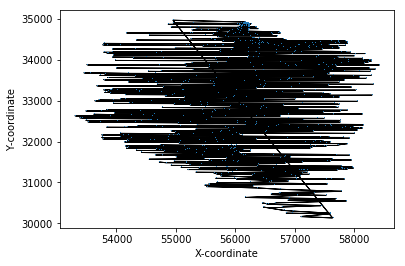

In [6]:
print(getObjValue(solution))
plotSolution(solution)

Het lijkt misschien alsof dit geen oplossing is tot het probleem, maar dat er veel meer lijnen staan. Dit is echter niet zo: in de dataset zitten een heel aantal coördinaten die héél dicht dicht bij elkaar liggen, waardoor het lijkt alsof een stad meer dan een keer bezocht wordt. Echter, dat er ruimte voor verbetering is, is duidelijk: Dat is aan jullie! Het notebook van het N-queens probleem kun je als inspiratiebron gebruiken (de class individual is bijvoorbeeld ook voor dit algoritme geschikt), maar voor een echt goed én persoonlijk algoritme, kun je natuurlijk ook nieuwe functies toevoegen aan het evolutionaire algoritme! Hieronder al een framework die je als uitgangsbasis kan gebruiken voor je algoritme.

Om te beginnen, een class voor het aanmaken van individuele oplossingen. Hierin hoeft in principe niets te worden aangepast, al gaat de initiele generatie van oplossingen nu volledig random. Hier zou je eventueel dingen in aan kunnen passen.

In [0]:
import random as rd

# Maak class individual aan
class Individual:
    def __init__(self, length, genes = None):
        self.length = length
        self.fitness = None
        if genes is not None:
            self.genes = genes
        else:
            self.genes = []*length


    # Initialiseer de genen random                                    --- Own input possible
    def Initialise(self):
        self.genes = rd.sample(range(self.length), self.length)

    # Maak een fitness functie om te berekenen hoe goed de huidige individu is (is identiek aan getObjValue(solution) van zojuist)
    def GetFitness(self, N):
        """
        Berekent de fitness van een individual
        :param self: individual
        """
        objective_value = 0
        for i in range(N-1):
            # Sum the distance from i to i + 1
            objective_value += distance_matrix[self.genes[i]][self.genes[i+1]]
        # Add the distance from the last city back to the first
        objective_value += distance_matrix[self.genes[N - 1]][self.genes[0]]
        self.fitness = objective_value
    
    # Dunder function om te kunnen itereren over de class
    def __getitem__(self, key):
        return self.genes[key]

Parent selection: Er zijn meerdere manieren om dit te doen, hieronder zijn er een aantal beschreven.

In [0]:
# Tournament Selection
def TournamentSelection(pop, size, tournament_size):
    """
    Geeft een populatie van parents op basis van tournament selection: Er worden tournament_size individuen geselecteerd
     uit pop waarvan degene met de hoogste fitness wint en toegevoegd wordt aan de parent populatie
    :param pop: De populatie die gebruikt wordt om parents van te selecteren
    :param size: De grootte van de parent populatie
    :param tournament_size: De grootte van een toernooi. Moet kleiner zijn dan population_size
    :return: de parent populatie
    """
    parent_pop = []
    for i in range(size):
        # selecteer tournament_size individuals (random sampling without replacement)
        tournament = rd.sample(pop, tournament_size)
        # selecteer de beste individual
        winner = np.argmin([i.fitness for i in tournament])
        # voeg deze toe aan parent_pop
        parent_pop.append(pop[winner])
    return(parent_pop)

In [0]:
# Fitness Proportional Selection
def FitnessProportionalSelection(pop, size):
    """
    Fitness Proportional Selection: Selecteer individuen op basis van hun fitness.
    Gebruik roulette wheel (stochastic universal sampling) om parents te selecteren
    :param pop: De populatie de gebruikt wordt om parents van te selecteren
    :param size: De grootte van de parent populatie
    """
    # Bereken de som van alle fitnesses (als normalizing factor). 1/antwoord om van min naar max probleem te komen
    S = sum([1.0/(i.fitness) for i in pop])
    # Afstand tussen ieder geselecteerd individu
    pointer_dist = S/size
    # Selecteer een random nummer tussen 0 en pointer_dist
    start = rd.uniform(0,pointer_dist)
    pointers = [start + i*pointer_dist for i in range(size)]
    
    parent_pop = []
    # Stochastic Universal Sampling: https://en.wikipedia.org/wiki/Stochastic_universal_sampling
    for p in pointers:
        i = 0
        # Zolang de som van de fitness van de individuen tot i lager is dan p, increment i
        while sum([1.0/(i.fitness) for i in pop[0:(i+1)]]) < p:
            i = i + 1
        # Als hij hoger gaat, voeg dan deze individu toe aan de populatie           
        parent_pop.append(pop[i])
    
    # Het is mogelijk dat hetzelfde individu meerdere keren voorkomt
    return(parent_pop)

In [0]:
# Rank Based Selection
def RankBasedSelection(pop, size):
    """
    Rank Based Selection: Selecteer individuen op basis van hun relatieve fitness t.o.v. de andere individuen.
    :param pop: De populatie de gebruikt wordt om parents van te selecteren
    :param size: De grootte van de parent populatie
    """
    # Sorteer de populatie op basis van hun fitness
    import operator
    pop.sort(key=operator.attrgetter('fitness'))
    
    # Calculate the fitness of the rank
    rank_fitness = [1.0/i for i in range(1,len(pop)+1)]
    
    # The remaining steps are the same as for fitness proportionate selection
    S = sum([i for i in rank_fitness])
    # Afstand tussen ieder geselecteerd individu
    pointer_dist = S/size
    # Selecteer een random nummer tussen 0 en pointer_dist
    start = rd.uniform(0,pointer_dist)
    pointers = [start + i*pointer_dist for i in range(size)]
    
    parent_pop = []
    # Stochastic Universal Sampling: https://en.wikipedia.org/wiki/Stochastic_universal_sampling
    for p in pointers:
        i = 0
        # Zolang de som van de fitness van de individuen tot i lager is dan p, increment i
        while sum([i for i in rank_fitness[0:(i+1)]]) < p:
            i = i + 1
        # Als hij hoger gaat, voeg dan deze individu toe aan de populatie           
        parent_pop.append(pop[i])
    
    # Het is mogelijk dat hetzelfde individu meerdere keren voorkomt
    return(parent_pop)

Cross over: Ook hier zijn er meerdere manieren om dit te doen

In [0]:
# Partially Mixed Crossover
def CrossOver(parent1, parent2, k, l):
    """
    crossover toegepast op twee parents
    :param parent1: parent 1
    :param parent2: parent 2
    :param k, l: breakpoints van de genen. Voor k  en na l wordt gebruikt van parent1, daarna van parent2
    :return: een kind met gecombineerde genen
    """

    child = []
    # Selecteer de te-gebruiken genen van parent 1 & 2
    childcenter = [parent1.genes[j] for j in range(k,l+1)]
    childedges = [parent2.genes[j] for j in range(0,N) if parent2.genes[j] not in childcenter]
    # Voeg de genen samen
    child[:k] = childedges[:k]
    child[k:l+1] = childcenter
    child[l+1:] = childedges[k:]

    return(child)

In [0]:
# def EdgeRecombination():
    # Voeg later toe

Child mutation: Muteer een child op een bepaalde manier. Ook hier zijn er meedere manieren mogelijk om mutatie te bereiken.

In [0]:
# Swap mutatie (wissel twee genen om)
def Swap(child, n):                                   
    """
    Wissel twee genen om
    :param child: child to be mutated
    :param n: number of mutations
    :return: mutated child
    """
    
    for i in range(n):
      # do a swap
      gene1 = rd.sample(range(N),1)[0]
      gene2 = rd.sample(range(N),1)[0]
      old = child[gene1]
      child[gene1] = child[gene2]
      child[gene2] = old
    
    return(child)

In [0]:
# 2-opt mutatie (verander de volgorde tussen twee posities)
def two_opt(child, n):
    """
    Doe een 2-opt stap twee genen
    :param child: child to be mutated
    :param n: number of mutations
    :return: mutated child
    """
    
    for i in range(n):
        # randomly select two genes
        gene1 = rd.sample(range(N),1)[0]
        gene2 = rd.sample(range(N),1)[0]
        if gene1 < gene2:
            a = gene1
            b = gene2
        elif gene2 < gene1:
            a = gene2
            b = gene1
        while gene1 == gene2:
            # resample
            gene1 = rd.sample(range(N),1)[0]
            if gene1 < gene2:
                a = gene1
                b = gene2
            elif gene2 < gene1:
                a = gene2
                b = gene1

        # Apply 2-opt procedure to the route between these genes (reverse order)
        child[a:b] = child[a:b][::-1]  
    return(child)

In [0]:
# Scramble mutatie (random herodering van genen tussen twee posities)
def Scramble(child, s):
    """
    Doe een 2-opt stap twee genen
    :param child: child to be mutated
    :param s: lengte van de subset die gescrambled wordt (s>1)
    :return: mutated child
    """
    
    # randomly select a position
    gene1 = rd.sample(range(N-s),1)[0]
    gene2 = gene1 + s

    # Scramble the genes between gene1 and gene2
    child[gene1:gene2] = rd.sample(child[gene1:gene2], s)  
    return(child)

Get best: verkrijg de beste huidige oplossing vanuit de populatie. Hierin hoeft in principe niets te worden aangepast.

In [0]:
def GetBest(population):
    """
    :param: de huidige populatie
    :return: return de beste individual van de huidige populatie
    """
    best = np.argmin([i.fitness for i in population])
    return(population[best])

De kern van de code: het aanroepen van alle functies.

Om zoveel mogelijk randomness te gebruiken, gebruiken we in iedere iteratie een ander mechanisme voor selectie en mutatie, aan de hand van een probability distribution. Indien we geen verbetering vinden, verhogen we de mutatiefactor. Dit om de kans te vergroten dat het algoritme uit een lokaal optimum kan ontsnappen.

De global parameters zijn bepaald door trial-and-error. De een zal beter werken dan de ander en dit is simpel een kwestie van uitproberen. Dit kun je ook op een slimme manier doen door een grid search te gebruiken.

In [0]:
# Global parameters
population_size = 10
tournament_size = 4
parent_size = 10
mutation_factor = 1
children_size = 20
scramble_size = 3

# distributie voor welk selectie mechanisme te gebruiken
Tournament_cdf = 0.3
FPS_cdf = 0.4
Rank_cdf = 1

# distributie voor welk mutatie mechanisme te gebruiken
Scramble_cdf = 0.5
two_opt_cdf = 0.75
Swap_cdf = 1

# Initialiseer de populatie random. (neem een goede oplossing mee, alles op volgorde van x-coordinaten)
population = [Individual(N) for i in range(population_size - 1)]
population.append(Individual(N, genes=list(range(N))))
for i in population:
   # Initialise random and calculate the fitness for each individual
   i.Initialise()
   i.GetFitness(N)   
population[0] = Individual(N,genes=solution)
population[0].GetFitness(N)


# Evolutionaire cyclus
i = 0
best_individual = GetBest(population).fitness
best_individual_1 = 0
n_no_improvements = 0
while n_no_improvements < 50000:   # stop als er 50 iteraties geen verbetering meer is geweest
    # Als er geen verbetering is geweest, verhoog dan de permutatie parameters
    if best_individual - best_individual_1 == 0:
        mutation_factor = max(mutation_factor + 1, 3)
        scramble_size = max(scramble_size + 1, 8)
        n_no_improvement = n_no_improvement + 1
    else:
        mutation_factor = 1
        scramble_size = 3
        n_no_improvement = 0
        
    
    # Select parents
    draw = rd.uniform(0,1)
    if draw < Tournament_cdf:
        parents = TournamentSelection(population, parent_size, tournament_size)
    elif draw < FPS_cdf:
        parents = FitnessProportionalSelection(population, parent_size)
    else:
        parents = RankBasedSelection(population, parent_size)   
    
    childs = []
    
    # Transfer the best children to the childrenset
    childs.append(GetBest(population))
    
    while len(childs) < children_size:
    
        # Selecteer parents uit de parent set
        parent1 = rd.sample(parents, 1)[0]
        parent2 = rd.sample(parents, 1)[0]
    
        # Create children by applying crossover
        (a,b) = rd.sample(range(N),2)
        k = min(a,b)
        l = max(a,b)
        child1 = CrossOver(parent1, parent2, k, l)
        child2 = CrossOver(parent2, parent1, k ,l)
    
        # Apply mutation to those children
        draw = rd.uniform(0,1)
        if draw < Scramble_cdf:
            child1 = Scramble(child1, scramble_size)
            child2 = Scramble(child2, scramble_size)
        elif draw < two_opt_cdf:
            child1 = two_opt(child1, mutation_factor)
            child2 = two_opt(child2, mutation_factor)  
        else:
            child1 = Swap(child1, mutation_factor)
            child2 = Swap(child2, mutation_factor)
    
        # Update childs
        childs.append(Individual(N,genes=child1))
        childs.append(Individual(N,genes=child2))
              
    # Calculate fitness
    [i.GetFitness(N) for i in childs]
    idx = np.argpartition([i.fitness for i in childs], population_size)
    # Update population
    index = [i for i in idx[:population_size]]
    population = [childs[i] for i in index]
    
    i = i + 1
    if i%100 == 0:
      print(str(GetBest(population).fitness) + " after iteration " + str(i))
    
    
GetBest(population)

print("Oplossing gevonden")

692193.1894964933 after iteration 100
623013.2468130266 after iteration 200
570042.0260280762 after iteration 300
537160.2149235653 after iteration 400
515525.3554475918 after iteration 500
500533.2392029567 after iteration 600
482623.07845708996 after iteration 700
470912.70155415474 after iteration 800
459088.54634381743 after iteration 900
448391.7500474048 after iteration 1000
435626.85672354844 after iteration 1100
427801.0906763759 after iteration 1200
417414.92482089007 after iteration 1300
405376.09531715093 after iteration 1400
398645.0004388856 after iteration 1500
393137.44667571265 after iteration 1600
385453.1330819195 after iteration 1700
378231.96222691255 after iteration 1800
372185.6908658453 after iteration 1900
363578.9590826836 after iteration 2000
358344.47404657985 after iteration 2100
351137.8322239258 after iteration 2200
347857.6730283878 after iteration 2300
343577.51566479774 after iteration 2400
338601.87318765087 after iteration 2500
334271.59491145227 afte

Stuur uiterlijk 20:40 je oplossing in .txt format naar lars@pipple.nl . De functie hieronder kun je gebruiken om je oplossing naar .txt format te krijgen.

In [0]:
from google.colab import files
def writetxt(solution, team_name = 'name'):
    with open(team_name + '.txt', 'w') as f:
        for i in solution:
            f.write("%s\n" % i)
    f.close()
    files.download(team_name + '.txt')

In [0]:
writetxt(GetBest(population).genes, team_name = "test")

In [0]:
print(GetBest(population).fitness)
plotSolution(GetBest(population).genes)